<a href="https://colab.research.google.com/github/difli/astra-vsearch-image/blob/main/astra-vsearch-image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# astra-vsearch-image
Jupyter notebook for image search powered by [Astra Vector Search](https://docs.datastax.com/en/astra-serverless/docs/vector-search/overview.html) and OpenAI [CLIP Model](https://github.com/openai/CLIP).

## OpenAI CLIP Model
CLIP, or "Contrastive Language-Image Pretraining", is an artificial intelligence model developed by OpenAI. The model is trained to understand and associate images with natural language by using a vast number of images and their associated textual descriptions. CLIP can perform tasks such as generating textual descriptions of images or finding images based on given text.

## Astra Vector Search
Astra vector search enables developers to search a database by context or meaning rather than keywords or literal values. This is done by using “embeddings”. Embeddings are a type of representation used in machine learning where high-dimensional or complex data is mapped onto vectors in a lower-dimensional space. These vectors capture the semantic properties of the input data, meaning that similar data points have similar embeddings.

## Demo Summary
The demo showcases the CLIP model, which generates embeddings for images. These embeddings, along with metadata, are stored in Astra DB. Specifically, the embeddings are stored in a column of type Vector. The goal of the demo is to utilize Astra Vector Search to find an image of a house with a swimming pool. The CLIP model generates embeddings based on the search string 'a house with a swimming pool'. These embeddings are then used in a query to find an image that shares similar embeddings with the search string, ultimately displaying an image of a house with a swimming pool.


# Getting Started with this notebook
1. Create a new ***vector search enabled database*** in [Astra](https://astra.datastax.com/).
   1. Create a keyspace
   2. Create a token with permissions to create tables
   3. Download your secure-connect-bundle.zip file.
2. Download [images.zip](https://github.com/difli/astra-vsearch-image/blob/main/images/images.zip?raw=true) file and unpack the zip file.
3. When you open this notebook in Google Colab or your own notebook server, drag-and-drop the following files in the File Browser of the notebook
   1. secure-connect-bundle.zip file and
   2. images (one.jpg, two.jpg, three.jpg and for.jpg)
4. Update the Environment Variables cell in the notebook with
   1. information from the token you generated (client id and client secret),
   2. the name of your secure-connect-bundle.zip file,
   3. the name of your keyspace
   4. The name of the table this notebook will create in Astra DB.

# Setup

In [ ]:
!pip3 install cassandra-driver matplotlib sentence-transformers

# Imports

In [ ]:
import os

from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

from PIL import Image
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

# Environment Variables

In [ ]:
import os
from google.colab import files


print('Please upload your Secure Connect Bundle')
uploaded = files.upload()
if uploaded:
    astraBundleFileTitle = list(uploaded.keys())[0]
    SECURE_CONNECT_BUNDLE_PATH = os.path.join(os.getcwd(), astraBundleFileTitle)
else:
    raise ValueError(
        'Cannot proceed without Secure Connect Bundle. Please re-run the cell.'
    )

ASTRA_CLIENT_ID = 'XmxZAlapMWyhiPcayDPFMUaN'
ASTRA_CLIENT_SECRET = 'e.aT9bdkvEguu-X,qOxQPL-NWvZY9qr+bUn7LN5tnzSpssuKO.KN7LJadUlQTJsP6dfLUz6WXduXM.BJiDqstt5FI92mTS_057nF0.haeFfd5o3tOLxiya4rvcraBgRX'
KEYSPACE_NAME = 'ks2'
TABLE_NAME = 'images'

Please upload your Secure Connect Bundle


Saving secure-connect-cassio-v1.zip to secure-connect-cassio-v1 (1).zip


# Connect to Astra DB

In [ ]:
cloud_config = {
   'secure_connect_bundle': SECURE_CONNECT_BUNDLE_PATH
}
auth_provider = PlainTextAuthProvider(ASTRA_CLIENT_ID, ASTRA_CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

ERROR:cassandra.connection:Closing connection <AsyncoreConnection(136468321424992) 66f0de79-38d3-4077-a4d5-1b94a6273948-us-east1.db.astra.datastax.com:29042:5903f2b2-4bfe-4035-9c52-a19adae6e381> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


# Drop / Create Schema

In [ ]:
print(f"Creating table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"CREATE TABLE IF NOT EXISTS {KEYSPACE_NAME}.{TABLE_NAME} (id int PRIMARY KEY, name TEXT, description TEXT, item_vector VECTOR<FLOAT, 512>)")

print(f"Creating index image_ann_index on table {TABLE_NAME} and inserting example data")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS image_ann_index ON {KEYSPACE_NAME}.{TABLE_NAME}(item_vector) USING 'StorageAttachedIndex'")

print(f"Truncate table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"TRUNCATE TABLE {KEYSPACE_NAME}.{TABLE_NAME}")


Creating table images in keyspace ks2
Creating index image_ann_index on table images and inserting example data
Truncate table images in keyspace ks2


# Load CLIP model

In [ ]:
model = SentenceTransformer('clip-ViT-B-32')

# Generate embeddings from images and load the table with data

In [ ]:
import os

!pwd
!ls /content/sample_data


/content
anscombe.json		      four.jpg		     one.jpg	two.jpg
california_housing_test.csv   mnist_test.csv	     README.md
california_housing_train.csv  mnist_train_small.csv  three.jpg


In [ ]:
img_emb1 = model.encode(Image.open('/content/sample_data/one.jpg'))
img_emb2 = model.encode(Image.open('/content/sample_data/two.jpg'))
img_emb3 = model.encode(Image.open('/content/sample_data/three.jpg'))
img_emb4 = model.encode(Image.open('/content/sample_data/four.jpg'))

image_data = [
    (1, 'one.jpg', 'description1', img_emb1.tolist()),
    (2, 'two.jpg', 'description2', img_emb2.tolist()),
    (3, 'three.jpg', 'description3', img_emb3.tolist()),
    (4, 'four.jpg', 'description4', img_emb4.tolist())
]

for image in image_data:
    session.execute(f"INSERT INTO {KEYSPACE_NAME}.{TABLE_NAME} (id, name, description, item_vector) VALUES {image}")


# Generate embeddings from query string

In [ ]:
query_string = "a house with swimming pool"
text_emb = model.encode(query_string)
print(f"model provided embeddings for the string: 'search': {text_emb.tolist()}")


model provided embeddings for the string: 'search': [0.13673922419548035, -0.016935274004936218, 0.1279873251914978, -0.19341346621513367, -0.04092840850353241, 0.020179636776447296, 0.17774268984794617, -0.7465459108352661, -0.13646283745765686, 0.2064562439918518, 0.1365462839603424, 0.13929443061351776, -0.12367454171180725, -0.026390492916107178, -0.018492519855499268, -0.006067031994462013, -0.12947775423526764, -0.01640058308839798, -0.1886979341506958, 0.076419897377491, 0.4420292377471924, -0.04835328459739685, -0.07441128045320511, -0.1532740294933319, -0.1728813648223877, 0.019104786217212677, 0.08113697171211243, 0.03689362853765488, 0.14817214012145996, 0.24959614872932434, 0.043250150978565216, -0.30260664224624634, -0.17066898941993713, 0.017186671495437622, -0.490842342376709, -0.16588303446769714, 0.061763130128383636, 0.288349449634552, 0.19461703300476074, 0.16320118308067322, -0.2056189477443695, 0.38503924012184143, -0.042073532938957214, -0.0014403462409973145, 0.2

# Vector search the image

Astra DB vector search query: SELECT name, description, item_vector FROM ks2.images ORDER BY item_vector ANN OF [0.13673922419548035, -0.016935274004936218, 0.1279873251914978, -0.19341346621513367, -0.04092840850353241, 0.020179636776447296, 0.17774268984794617, -0.7465459108352661, -0.13646283745765686, 0.2064562439918518, 0.1365462839603424, 0.13929443061351776, -0.12367454171180725, -0.026390492916107178, -0.018492519855499268, -0.006067031994462013, -0.12947775423526764, -0.01640058308839798, -0.1886979341506958, 0.076419897377491, 0.4420292377471924, -0.04835328459739685, -0.07441128045320511, -0.1532740294933319, -0.1728813648223877, 0.019104786217212677, 0.08113697171211243, 0.03689362853765488, 0.14817214012145996, 0.24959614872932434, 0.043250150978565216, -0.30260664224624634, -0.17066898941993713, 0.017186671495437622, -0.490842342376709, -0.16588303446769714, 0.061763130128383636, 0.288349449634552, 0.19461703300476074, 0.16320118308067322, -0.2056189477443695, 0.385039240

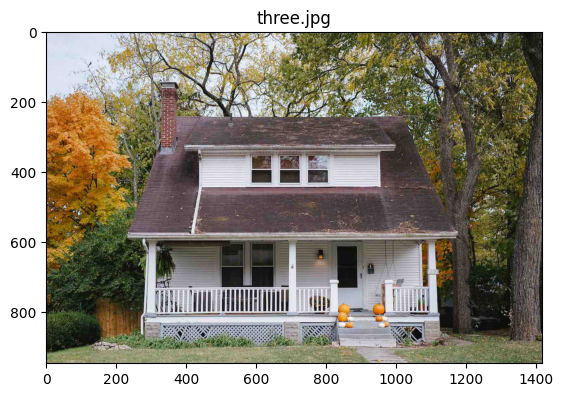

In [ ]:
print(f"Astra DB vector search query: SELECT name, description, item_vector FROM {KEYSPACE_NAME}.{TABLE_NAME} ORDER BY item_vector ANN OF {text_emb.tolist()} LIMIT 1")
for row in session.execute(f"SELECT name, description, item_vector FROM {KEYSPACE_NAME}.{TABLE_NAME} ORDER BY item_vector ANN OF {text_emb.tolist()} LIMIT 1"):
    print("\t" + str(row))
    plt.title(row.name)
    image = mpimg.imread('/content/sample_data/' + row.name)
    plt.imshow(image)
    plt.show()